# Data Preperation for 48 state fuel data

I collected all the fuel reciepts on my 48 USA state road trip in Dec 2021. After the trip I created a CSV file with the reciept details. This project is about creating some insights from this data. Since, this data is collected by me and may lack few descriptors, I decided to incorporporate other features from different sources. For example, I can download population and state area data for USA states from the internet. All of these resources are referenced wherever needed.


In [1]:
# Import libraries 

import pandas as pd
import numpy as np

First, lets prepare the fuel data from the collected reciepts.

## Fuel data preperation steps

### Step 1: Load fuel data 

Read the data from fuel reciepts file. This file is saved at "data/fuel_data.csv"

In [2]:
df = pd.read_csv("data/fuel_data.csv")
df.head()

,Date,Time,StateCode,Rate,Quantity,Total,RecieptTotal,GasCompany,CostcoNumber
0,12/13/2021,09:48,MI,2.799,3.424,9.583776,9.58,Costco,393.0
1,12/13/2021,15:27,IN,2.949,9.362,27.608538,27.61,Costco,370.0
2,12/14/2021,07:28,WI,2.789,9.895,27.597155,27.60,Costco,1121.0
3,12/14/2021,15:29,IA,3.070,9.772,30.000040,30.00,Caseys,NaN
4,12/15/2021,08:43,MN,2.849,8.469,24.128181,24.13,Costco,1344.0


### Step 2: Drop columns

We will be dropping 'Date', 'Time' and 'CostcoNumber' from the dataframe

In [3]:
df.drop(columns = ['Date', 'Time' , 'CostcoNumber'], inplace=True)

### Step 3: Rate correction

It is well know that gasoline price at Costco is cheaper compared to other gas companies. Assume costco sells gasoline at a rate $0.30 less than any other gas station, update the rate. [https://www.gobankingrates.com/saving-money/car/why-costco-membership-worth-it-just-for-gas-prices/](https://www.gobankingrates.com/saving-money/car/why-costco-membership-worth-it-just-for-gas-prices/)

In [4]:
df['Rate'] = np.where(df['GasCompany']=='Costco', df['Rate'] + 0.30, df['Rate'] )
df.head()

,StateCode,Rate,Quantity,Total,RecieptTotal,GasCompany
0,MI,3.099,3.424,9.583776,9.58,Costco
1,IN,3.249,9.362,27.608538,27.61,Costco
2,WI,3.089,9.895,27.597155,27.60,Costco
3,IA,3.070,9.772,30.000040,30.00,Caseys
4,MN,3.149,8.469,24.128181,24.13,Costco


### Step 4: Amount correction

Update the total amount spend on gas based on corrected Rate in the previous step

In [5]:
df['Total'] = df['Rate']*df['Quantity']
df['Total'] = df['Total'].round(2)
df.head()

,StateCode,Rate,Quantity,Total,RecieptTotal,GasCompany
0,MI,3.099,3.424,10.61,9.58,Costco
1,IN,3.249,9.362,30.42,27.61,Costco
2,WI,3.089,9.895,30.57,27.60,Costco
3,IA,3.070,9.772,30.00,30.00,Caseys
4,MN,3.149,8.469,26.67,24.13,Costco


### Step 5: Group data

Group data based on State Code:
- Rate is the average of each group
- Quantity is the sum on each group
- Total is calculated based on updated Rate and Quantity 
- Drop last two columns 'RecieptTotal' and 'GasCompany'

In [6]:
df = (df.groupby('StateCode').agg({'Rate':'mean', 'Quantity':'sum'}))

df['Total'] = df['Rate']*df['Quantity']
df['Total'] = df['Total'].round(2)
#df.set_index('StateCode',inplace=True)
print(df)

            Rate  Quantity   Total
StateCode                         
AL         2.999    9.5520   28.65
CO         3.259    7.6880   25.06
CT         3.499    9.6220   33.67
DE         3.499    8.8980   31.13
GA         3.099    7.8640   24.37
IA         3.070    9.7720   30.00
IN         3.249    9.3620   30.42
KS         3.049    6.7230   20.50
MI         3.099    8.7940   27.25
MN         3.149    8.4690   26.67
MO         2.849   20.4710   58.32
MS         2.764   16.5810   45.83
MT         3.463   36.2110  125.40
NC         3.179    7.7760   24.72
ND         3.164   18.8220   59.55
NE         3.070    9.0450   27.77
NH         3.199    9.3630   29.95
NV         3.719   29.5000  109.71
NY         3.449   17.7560   61.24
OH         3.069    7.3030   22.41
OK         2.849    9.9840   28.44
OR         3.879   14.8120   57.46
TN         2.709    8.8610   24.00
TX         2.690    7.4366   20.00
UT         3.629   13.4840   48.93
VA         3.399    9.6120   32.67
WA         3.589    

<AxesSubplot:xlabel='StateCode'>

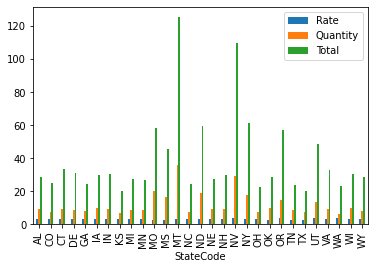

In [7]:
df.plot.bar()

## Data analysis

Now, we can try to answer some of the questions based on this cleaned data. 

### Q1. Which state has the cheapest and most expensive gasoline rate?

<AxesSubplot:xlabel='StateCode'>

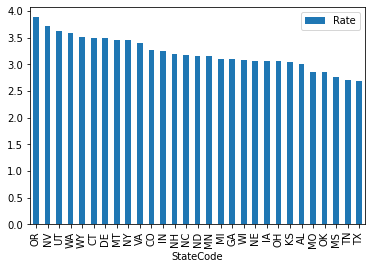

In [8]:
df.sort_values('Rate', ascending=False)[['Rate']].plot.bar()

From the graph above, one may conclude Gasoline rates are highest in Oregon (OR) and lowest in Texas (TX)

### Q2. In which state I spend most and least on gas?  

<AxesSubplot:xlabel='StateCode'>

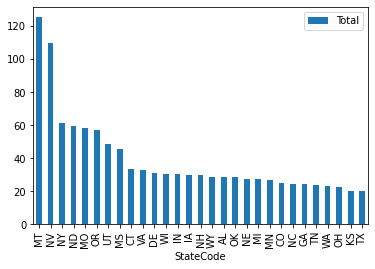

In [9]:
df.sort_values('Total', ascending=False)[['Total']].plot.bar()

Clearly, MT and NV stand out. Let's add state area as one variable to explain this spike. 

### Q2. Can we predict the gas price of the missing states using a ML model?

Since we do not have a complete dataset of all USA states, lets download one with the addition of latitude and latitude. Lat and Long will be used as the predictor variables and rate would an estimate. This can be achieved by merging two datasets, a) US states with lat and long, and b) Current gasoline rate from AAA website. I will alos download the gasoline data for dec 2021 to compare the estimated rate with actual rate.

## State data preparation steps

### Step 1: Download state, latitude and longitude data from Kaggle

[https://www.kaggle.com/datasets/washimahmed/usa-latlong-for-state-abbreviations?resource=download](https://www.kaggle.com/datasets/washimahmed/usa-latlong-for-state-abbreviations?resource=download)

### Step 2: Download current average gasoline price data for USA state wise from AAA



In [ ]:

import pandas as pd

import numpy as np

df1 = pd.read_csv("data/fuel_current.csv",delimiter='\t')
print(df1)

### Step 3: Download Dec 2021 average gasoline price data for USA state wise from AAA

### Step 4: Build a Machine Learning model to predict gas price based on latitude and longitude

### Q3. How does including population, gdp, gas tax, state area, and other features affect the machine leaarnign model?

Population data:
[https://www2.census.gov/programs-surveys/popest/tables/2020-2021/state/](https://www2.census.gov/programs-surveys/popest/tables/2020-2021/state/)

Population, Area, State Code data:

https://github.com/jakevdp/data-USstates


In [15]:
df_rate = pd.read_csv('data/state_fuelprice.csv',sep='\t')
df_rate = df_rate[['State','Regular']]
df_rate['Regular'] = pd.to_numeric(df_rate['Regular'].str.replace("$",""))
df_rate

,State,Regular
0,Alaska,5.194
1,Alabama,4.302
2,Arkansas,4.115
3,Arizona,4.887
4,California,6.069
5,Colorado,4.147
6,Connecticut,4.686
7,District of Columbia,4.856
8,Delaware,4.601
9,Florida,4.477


<AxesSubplot:>

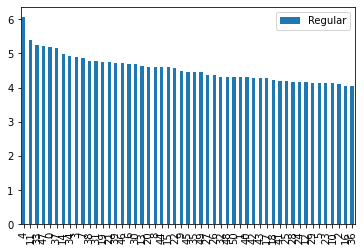

In [16]:
df_rate.sort_values('Regular', ascending=False)[['Regular']].plot.bar()

In [17]:
df_code = pd.read_csv("data/state_code.csv")
df_code

,state,abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA
5,Colorado,CO
6,Connecticut,CT
7,Delaware,DE
8,District of Columbia,DC
9,Florida,FL


In [ ]:
# merge table